Origen de datos:https://www.kaggle.com/NUFORC/ufo-sightings#complete.csv

Context
This dataset contains over 80,000 reports of UFO sightings over the last century.

Content
There are two versions of this dataset: scrubbed and complete. The complete data includes entries where the location of the sighting was not found or blank (0.8146%) or have an erroneous or blank time (8.0237%). Since the reports date back to the 20th century, some older data might be obscured. Data contains city, state, time, description, and duration of each sighting.

Inspiration
What areas of the country are most likely to have UFO sightings?
Are there any trends in UFO sightings over time? Do they tend to be clustered or seasonal?
Do clusters of UFO sightings correlate with landmarks, such as airports or government research centers?
What are the most common UFO descriptions?
Acknowledgement
This dataset was scraped, geolocated, and time standardized from NUFORC data by Sigmond Axel here.

In [1]:
import pandas as pd
import time
from datetime import date
from datetime import time
import matplotlib.pyplot as plt

data = pd.read_csv('./UFO.csv')

/home/laura/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
data.shape

(88875, 14)

In [3]:
data.columns

Index(['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13'],
      dtype='object')

In [4]:
data.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.9411111,NaN,NaN,NaN
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082,NaN,NaN,NaN
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667,NaN,NaN,NaN
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.6458333,NaN,NaN,NaN
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.8036111,NaN,NaN,NaN


In [5]:
data.dtypes

datetime                 object
city                     object
state                    object
country                  object
shape                    object
duration (seconds)       object
duration (hours/min)     object
comments                 object
date posted              object
latitude                 object
longitude                object
Unnamed: 11              object
Unnamed: 12             float64
Unnamed: 13             float64
dtype: object

In [6]:
data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce') #datetime to datetime
data['duration (seconds)'] = pd.to_numeric(data['duration (seconds)'], errors='coerce') #duration (seconds) to float
data['latitude'] = pd.to_numeric(data['latitude'], errors='coerce') #latitud to float
data['longitude'] = pd.to_numeric(data['longitude'], errors='coerce') #longitude to float
data.dtypes
data['city'] = data['city'].str.title()
data['state'] = data['state'].str.upper()

In [7]:
print(data['duration (seconds)'].max())
print(data['duration (seconds)'].min())

97836000.0
0.0


In [8]:
data['Unnamed: 11'].value_counts().head()

0               173
0.0              56
-74.0063889      10
-111.093731       6
-122.3308333      4
Name: Unnamed: 11, dtype: int64

In [9]:
data['Unnamed: 12'].value_counts().head()

 0.000000     6
 24.857883    4
-46.633309    1
-28.673147    1
-93.019722    1
Name: Unnamed: 12, dtype: int64

In [10]:
data['Unnamed: 13'].value_counts().head()

-23.126667    1
 0.000000     1
Name: Unnamed: 13, dtype: int64

In [11]:
print(data['datetime'].min())
print(data['datetime'].max())

1906-11-11 00:00:00
2014-05-08 18:45:00


In [37]:
#split in date and time:
data['date'] = [d.date() for d in data['datetime']]
data['year'] = data.datetime.dt.year

data['time'] = data.datetime.dt.time
data.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,Unnamed: 11,Unnamed: 12,Unnamed: 13,date,time,year
0,1949-10-10 20:30:00,San Marcos,TX,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,NaN,NaN,NaN,1949-10-10,20:30:00,1949.0
1,1949-10-10 21:00:00,Lackland Afb,TX,NaN,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082,NaN,NaN,NaN,1949-10-10,21:00:00,1949.0
2,1955-10-10 17:00:00,Chester (Uk/England),NaN,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667,NaN,NaN,NaN,1955-10-10,17:00:00,1955.0
3,1956-10-10 21:00:00,Edna,TX,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,NaN,NaN,NaN,1956-10-10,21:00:00,1956.0
4,1960-10-10 20:00:00,Kaneohe,HI,us,light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,NaN,NaN,NaN,1960-10-10,20:00:00,1960.0


In [39]:
data['country'].unique()

array(['us', nan, 'gb', 'ca', 'au', 'nv', 'ms', 'tx', 'qc', 'r&eth', 'co',
       'de', 'mo', 'fl', 'on', 'il', ' w)', ' (catalunya) (spain)', 'ne',
       'wv', ' (finland)', 'ny', 'or', 'vt', 'mb', 'wa', 'tn', 'ga', 'wi',
       ' 90 e on highway)', ' ??) (canada)', 'az', 'nh', ' 37000 ft.)',
       'ks', 'al', 'va', 'ok', 'nj', 'bec)', 'md', 'nc',
       ' we were traveling)', ' pod ralskem (czech republic)',
       'n (sweden)', 'ri', 'pa', ' (sweden)', 'nm', 'wek (poland)', 'ct',
       'sc', 'y (norway)', 'ar', 'pq', 'ab', 'mt', 'hi', 'ut',
       'sand (sweden)', 'in', 'mi', 'a (argentina)', ' on cruise ship)',
       ')', 'nd', 'e)', 'id', 'ma', 'ky', ' enroute)',
       'rito santo state) (brazil)', 'bc', 'wy', '&#8218', 'ia', 'la',
       'ak', ' 56)', 'dc', ' close to gilroy)', 'ns',
       ' cerro prieto.&#44 b. c.', 'ndelag (norway)', 'me'], dtype=object)

In [40]:
data.isnull().sum()
#hay que eliminar las columnas: Unnamed: 11 (88197), Unnamed: 12 (88836), Unnamed: 13 (88873)

datetime                 1262
city                      196
state                    7396
country                 12401
shape                    3358
duration (seconds)        403
duration (hours/min)     3090
comments                  154
date posted                 3
latitude                  679
longitude                  39
Unnamed: 11             88197
Unnamed: 12             88836
Unnamed: 13             88873
date                     1262
time                     1262
year                     1262
dtype: int64

In [41]:
# eliminamos las columnas que tienen casi todos los valores, nulos, y las filas con algun valor nuloççççççç:
data1 = data.drop(['Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13','duration (hours/min)'], axis=1).dropna(axis=0, how='any', inplace=False)
data1.shape

(70420, 13)

In [42]:
data1.isnull().sum()

datetime              0
city                  0
state                 0
country               0
shape                 0
duration (seconds)    0
comments              0
date posted           0
latitude              0
longitude             0
date                  0
time                  0
year                  0
dtype: int64

In [43]:
data1.shape

(70420, 13)

In [44]:
data1.city.value_counts()

Seattle                              488
Phoenix                              461
Las Vegas                            376
Portland                             370
Los Angeles                          361
San Diego                            344
Houston                              305
Chicago                              282
Tucson                               250
Miami                                245
Orlando                              226
Austin                               218
Springfield                          217
Albuquerque                          214
Columbus                             207
Sacramento                           206
Denver                               193
San Francisco                        193
San Jose                             192
San Antonio                          189
Jacksonville                         176
Toronto (Canada)                     175
Dallas                               169
Myrtle Beach                         163
Charlotte       

In [45]:
#data1.city = data1.city.replace("(Canada)", " ")
data1.replace({'city': {'Canada',''}})
data1.city.value_counts()

Seattle                              488
Phoenix                              461
Las Vegas                            376
Portland                             370
Los Angeles                          361
San Diego                            344
Houston                              305
Chicago                              282
Tucson                               250
Miami                                245
Orlando                              226
Austin                               218
Springfield                          217
Albuquerque                          214
Columbus                             207
Sacramento                           206
Denver                               193
San Francisco                        193
San Jose                             192
San Antonio                          189
Jacksonville                         176
Toronto (Canada)                     175
Dallas                               169
Myrtle Beach                         163
Charlotte       

In [46]:
#data1.to_csv("UFO_modify1.csv")

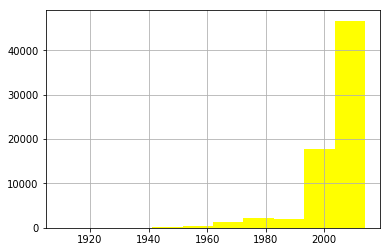

In [51]:
data1.year.hist(histtype= 'stepfilled', color = "yellow")

In [56]:
data_year = pd.DataFrame(data1.groupby('year').count())
data_year

,datetime,city,state,country,shape,duration (seconds),comments,date posted,latitude,longitude,date,time
year,,,,,,,,,,,,
1910.0,2,2,2,2,2,2,2,2,2,2,2,2
1920.0,1,1,1,1,1,1,1,1,1,1,1,1
1925.0,1,1,1,1,1,1,1,1,1,1,1,1
1929.0,1,1,1,1,1,1,1,1,1,1,1,1
1930.0,1,1,1,1,1,1,1,1,1,1,1,1
1931.0,2,2,2,2,2,2,2,2,2,2,2,2
1934.0,1,1,1,1,1,1,1,1,1,1,1,1
1936.0,3,3,3,3,3,3,3,3,3,3,3,3
1937.0,1,1,1,1,1,1,1,1,1,1,1,1
